### Building the dataset 

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
REBUILD_DATA = False

In [3]:
class FemaleVsMaleEyes():
    
    IMG_SIZE = 50
    FEMALES = "femaleeyes"
    MALES = "maleeyes"
    LABELS = {FEMALES: 0, MALES: 1}
    training_data = []

    femalecount = 0
    malecount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                        if label == self.FEMALES:
                            self.femalecount += 1
                        elif label == self.MALES:
                            self.malecount += 1

                    except Exception as e:
                        pass

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
                

In [4]:
if REBUILD_DATA:
    femalevsmaleEyes = FemaleVsMaleEyes()
    femalevsmaleEyes.make_training_data()
    
    print('Females:',femalevsmaleEyes.femalecount)
    print('Males:',femalevsmaleEyes.malecount)

In [5]:
training_data = np.load("training_data.npy", allow_pickle = True)
print(len(training_data))

11525


### Checking a random picture

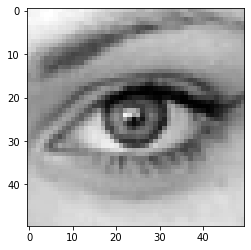

Female Eye


In [32]:
import matplotlib.pyplot as plt

random_sample = np.random.randint(len(training_data))

plt.imshow(training_data[random_sample][0], cmap = "gray")
plt.show()

if training_data[random_sample][1][0] == 0: print("Male Eye")
else: print("Female Eye")

### Building the Neural Network

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        self._to_linear = None
        self.convs(torch.randn(50,50).view(-1,1,50,50)) # to figure out input shape of fc1

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2) 

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)


### Enable GPU if available

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

net = Net().to(device)
print(net)


Running on the GPU
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


### Split data set into training and testing 

In [9]:
def get_train_test_data(training_data, VAL_PCT = 0.1):
    
    X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
    X = X/255.0
    y = torch.Tensor([i[1] for i in training_data])

    val_size = int(len(X)*VAL_PCT)

    train_X = X[:-val_size]
    train_y = y[:-val_size]

    test_X = X[-val_size:]
    test_y = y[-val_size:]
    
    return train_X.to(device), train_y.to(device), test_X.to(device), test_y.to(device)

train_X, train_y, test_X, test_y = get_train_test_data(training_data)
    

### Forward Pass and test function for both training and validation

In [10]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def fwd_pass(X, y, train=False):

    if train:
        net.zero_grad()
    outputs = net(X)

    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss

In [11]:
def validation_test(size=100):
    
    random_start = np.random.randint(len(test_X)-size)
    
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50), y)
    return val_acc, val_loss


### Training

In [12]:
import time

def get_model_results_dict():
    return({
        "times": [],
        "accuracies": [],
        "losses": [],
        "val_accs": [],
        "val_losses": []
    })

def train(net, BATCH_SIZE = 100, EPOCHS = 2):
    model_results_dict = get_model_results_dict()
    
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X, batch_y

            acc, loss = fwd_pass(batch_X, batch_y, train=True)

            if i % 50 == 0:
                val_acc, val_loss = validation_test(size=100)
                
                model_results_dict["times"].append(round(time.time(),3))
                model_results_dict["accuracies"].append(round(float(acc),2))
                model_results_dict["losses"].append(round(float(loss), 4))
                model_results_dict["val_accs"].append(round(float(val_acc),2))
                model_results_dict["val_losses"].append(round(float(val_loss),4))
                
    return(model_results_dict)

results = train(net, EPOCHS = 30)

100%|██████████| 104/104 [00:03<00:00, 29.99it/s]


### Validation Results

<Figure size 432x288 with 0 Axes>

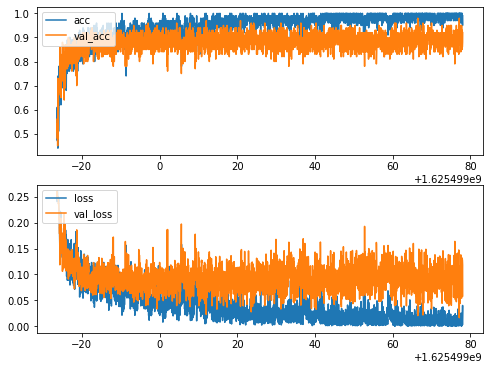

In [13]:
import matplotlib.pyplot as plt

def create_acc_loss_graph(results):
    
    fig = plt.figure()
    plt.figure(figsize=(8,6))
    
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(results["times"], results["accuracies"], label="acc")
    ax1.plot(results["times"], results["val_accs"], label="val_acc")
    ax1.legend(loc=2)
    
    ax2.plot(results["times"],results["losses"], label="loss")
    ax2.plot(results["times"],results["val_losses"], label="val_loss")
    ax2.legend(loc=2)
    
    plt.show()

create_acc_loss_graph(results)

In [28]:
print(f'Initial Validation Accuracy: {results["val_accs"][0] * 100:.2f}%')
print(f'Initial Validation Loss: {results["val_losses"][0]}\n')

print(f'Final Validation Accuracy: {results["val_accs"][-1] * 100:.2f}%')
print(f'Final Validation Loss: {results["val_losses"][-1]}')

Initial Validation Accuracy: 56.00%
Initial Validation Loss: 0.2473

Final Validation Accuracy: 92.00%
Final Validation Loss: 0.0584


In [27]:
print(f'Initial Training Accuracy: {results["accuracies"][0] * 100:.2f}%')
print(f'Initial Training Loss: {results["losses"][0]}\n')

print(f'Final Training Accuracy: {results["accuracies"][-1] * 100:.2f}%')
print(f'Final Training Loss: {results["losses"][-1]}')

Initial Training Accuracy: 48.00%
Initial Training Loss: 0.2502

Final Training Accuracy: 99.00%
Final Training Loss: 0.0037
